In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# BEFORE YOU RUN
## Data Structure Should be:
### data / 
###        cyber_dataset
####                    /auth.txt.gs * very large, working on getting a workable version
####                    /redteam.txt.gz
###        elliptic_bitcoin_dataset
####                               /elliptic_txs_classes.csv
####                               /elliptic_txs_edgelist.csv
####                               /elliptic_txs_features.csv
###        keystroke_dynamics_dataset/DSL-StrongPasswordData.csv

About the Data:
- Elliptic is already a graph. It has 2% illicit data, the rest is licit. 
- Few things to check out: is the data clustered in specific time windows or not?

- For device/auth signals, this data is pretty massive. We need to downsample to be able to manage number of users. 
- We can explore how many users log into a single machine. Maybe a "normal" number of devices per user, things like that

- Behavioral data is micro-features for the nodes. We can analyze the variance in keystoke hold times. Maybe some sort of behavioral fingerprint for a user that changes when an account is compromised.

Mapping the Data
- These obviouslly aren't natively connected, we need to do this ourselves. For example, User_ID -> Wallet_ID and Device_ID -> Login_Session or something like that. 
- This could help us map User A logs in from Device B (unusual) with a typing cadence that doesn't match their profile, then immediately sends Bitcoin to an Illicit node in the Elliptic graph

In [42]:
# Read in the Datasets
df_labels = pd.read_csv('data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv') # maps transaction IDs to licit, illicit, unknown
df_edges = pd.read_csv('data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv') # the adjacency list [who sent money to who]
df_features = pd.read_csv('data/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None) # 166 features for each transaction

In [43]:
# 1. Rename columns for clarity
# The features file usually doesn't have headers. Column 0 is the ID, Column 1 is Time Step.
df_features.columns = ['txId', 'time_step'] + [f'feat_{i}' for i in range(165)]

# 2. Merge labels and features into a master Node Dataframe
df_nodes = pd.merge(df_features, df_labels, on='txId')

In [44]:
class_map = {'1': 1, '2': 2, 'unknown': -1}
df_nodes['class'] = df_nodes['class'].map(class_map)
print(df_nodes['class'].value_counts())
# We have a lot of unknown nodes we can work with. Train on the known ones and see if we can classify the unknowns later 

class
-1    157205
 2     42019
 1      4545
Name: count, dtype: int64


In [54]:
df_nodes.head()

,txId,time_step,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_156,feat_157,feat_158,feat_159,feat_160,feat_161,feat_162,feat_163,feat_164,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,-1
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,-1
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,-1


In [55]:
df_features.head()

,txId,time_step,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_155,feat_156,feat_157,feat_158,feat_159,feat_160,feat_161,feat_162,feat_163,feat_164
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [56]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


<Axes: xlabel='time_step'>

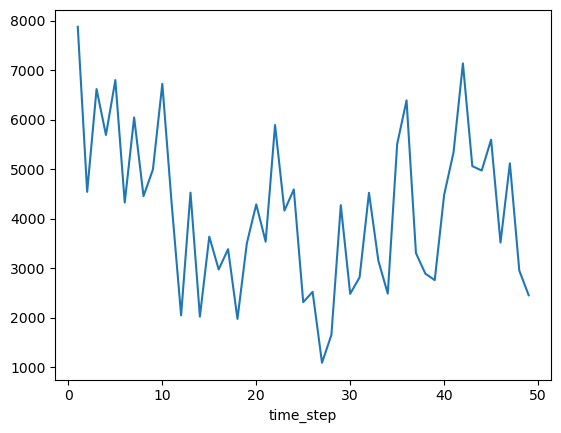

In [46]:
# temporal dist
df_nodes.groupby('time_step')['class'].count().plot()

In [47]:
# graph density 
num_nodes = df_nodes.shape[0]
num_edges = df_edges.shape[0]
density = num_edges / (num_nodes * (num_nodes - 1))
print(f"Graph Density: {density:.6f}")
#sparse graph is excpected for real world networks, network is highly efficient.

Graph Density: 0.000006


In [48]:
len(df_edges)/len(df_nodes)  # avg degree

1.1501013402431184

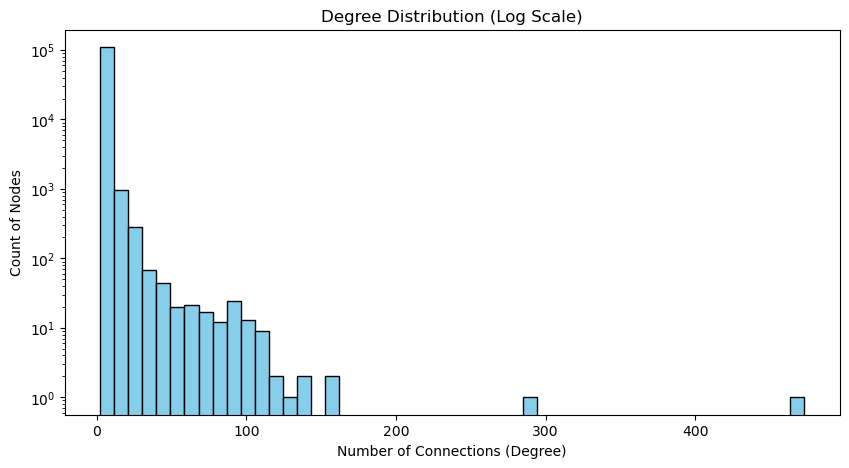

In [49]:
# Calculate degree for each node
# In-degree: how many transactions flow INTO this tx
# Out-degree: how many transactions flow OUT of this tx
degrees = df_edges['txId1'].value_counts() + df_edges['txId2'].value_counts()

plt.figure(figsize=(10, 5))
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black')
plt.title("Degree Distribution (Log Scale)")
plt.xlabel("Number of Connections (Degree)")
plt.ylabel("Count of Nodes")
plt.show()

Interpreting with some context here:
- the average degree is 1.15ish, meaning that any node with a degree of 10, 20, or more, is likely a major outlier and this represents mixing services or consolidation points 
- Because of sparsity, we should use GraphSAGE or GCN because it aggregates neighbors information without being overwhelmed by noise. 

- Another thing, isolated clusters can be highly suspicious. There are a lot of disjointed clusters in this data. So, most nodes do not see each other. We need to rely on local neighborhood features because of this!

In [50]:
# 1. Create the Graph object from your edgelist
G = nx.from_pandas_edgelist(df_edges, source='txId1', target='txId2', create_using=nx.Graph())

# 2. Find all connected components
components = list(nx.connected_components(G))

# 3. Sort components by size (largest first)
components.sort(key=len, reverse=True)

# 4. Get the Largest Connected Component
lcc = G.subgraph(components[0])

print(f"Total nodes in full graph: {G.number_of_nodes()}")
print(f"Nodes in the Largest Connected Component: {lcc.number_of_nodes()}")
print(f"Percentage of nodes in LCC: {100 * lcc.number_of_nodes() / G.number_of_nodes():.2f}%")

Total nodes in full graph: 203769
Nodes in the Largest Connected Component: 7880
Percentage of nodes in LCC: 3.87%


In [51]:
# Create a mapping of txId to class for quick lookup
node_class_dict = dict(zip(df_nodes['txId'], df_nodes['class']))

# Analyze the top 10 largest components
for i, comp in enumerate(components[:10]):
    # Count classes in this component
    classes_in_comp = [node_class_dict.get(node, -1) for node in comp]
    
    fraud_count = classes_in_comp.count(1)
    licit_count = classes_in_comp.count(0)
    unknown_count = classes_in_comp.count(-1)
    
    print(f"Component {i+1} | Size: {len(comp)} | Fraud: {fraud_count} | Licit: {licit_count} | Unknown: {unknown_count}")

Component 1 | Size: 7880 | Fraud: 17 | Licit: 0 | Unknown: 5733
Component 2 | Size: 7140 | Fraud: 239 | Licit: 0 | Unknown: 4986
Component 3 | Size: 6803 | Fraud: 8 | Licit: 0 | Unknown: 4921
Component 4 | Size: 6727 | Fraud: 18 | Licit: 0 | Unknown: 5755
Component 5 | Size: 6621 | Fraud: 11 | Licit: 0 | Unknown: 5342
Component 6 | Size: 6393 | Fraud: 33 | Licit: 0 | Unknown: 4685
Component 7 | Size: 6048 | Fraud: 102 | Licit: 0 | Unknown: 4845
Component 8 | Size: 5894 | Fraud: 158 | Licit: 0 | Unknown: 4131
Component 9 | Size: 5693 | Fraud: 30 | Licit: 0 | Unknown: 4253
Component 10 | Size: 5598 | Fraud: 5 | Licit: 0 | Unknown: 4377


In [ ]:
# we could use this to create risk scores for unknown nodes based on their proximity to known fraudulent nodes in the graph.

### NEXT DATA
KEYSTROKES

In [59]:
# Load the dataset
df_bio = pd.read_csv('data/keystroke_dynamics_dataset/DSL-StrongPasswordData.csv')

In [60]:
df_bio.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [65]:
df_bio.columns

Index(['subject', 'sessionIndex', 'rep', 'H.period', 'DD.period.t',
       'UD.period.t', 'H.t', 'DD.t.i', 'UD.t.i', 'H.i', 'DD.i.e', 'UD.i.e',
       'H.e', 'DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r',
       'UD.five.Shift.r', 'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o', 'H.o',
       'DD.o.a', 'UD.o.a', 'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l',
       'UD.n.l', 'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return'],
      dtype='object')

In [63]:
# Basic Stats: How many users and how many samples per user?
num_users = df_bio['subject'].nunique()
samples_per_user = df_bio.groupby('subject').size().iloc[0]
print(f"Total Users: {num_users}")
print(f"Samples per User: {samples_per_user}")

Total Users: 51
Samples per User: 400


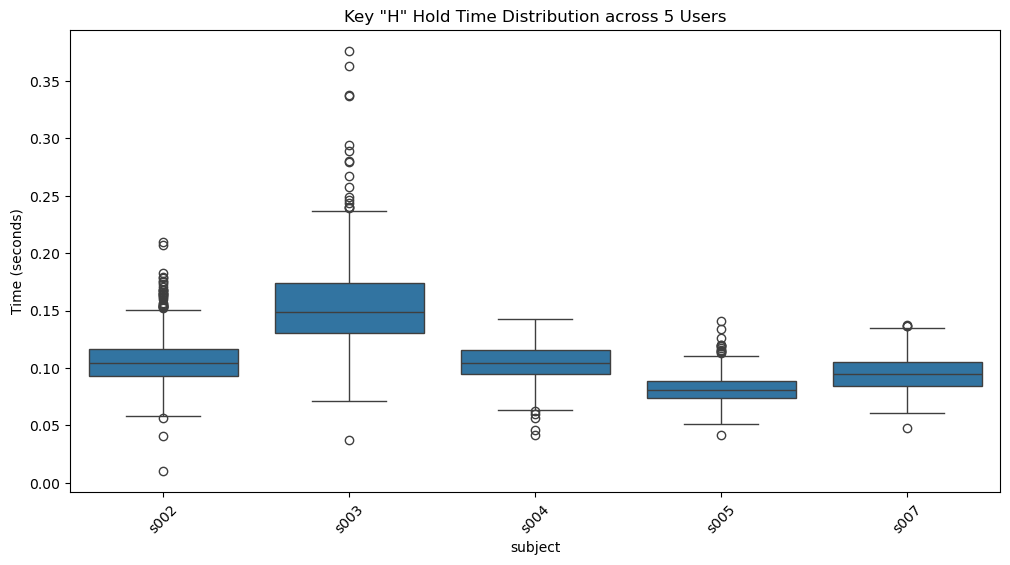

In [64]:
# Select a few users to compare
sample_users = df_bio['subject'].unique()[:5]
df_sample = df_bio[df_bio['subject'].isin(sample_users)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='subject', y='H.period', data=df_sample)
plt.title('Key "H" Hold Time Distribution across 5 Users')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.show()

We could try some synethic cross-channel linking of this data artficially. This could look like s002 (keystrokes) -> txID_12345 (elliptic). Some issues with this...
- There are only 51 users, and about 200k transactions, so the data would be very repetitive.
- We could limit where we merge (active components, ignoring unknown nodes, etc) and only work with that small subsections.

The next dataset is harder to work with due to file sizes:
- auth.txt.gz, we NEED this one. It has auth events and is the device/access layer 
- redteam.txt.gz, pretty much need this. Contains confirmed malicious activity. can see timestamps/users to simulate the start of a fraud event in the graph
- proc.txt.gz, probably DONT need this. It has start/stop events and can detect bot behavior, maybe a nice to have later
- dnd.txt.gz, probably DONT need this. DND lookup events, useful for network security, but harder to map to financial fraud. can ignore

We can join with src_user and src_comp to make a heterogeneous graph where edges are "Sent Money To" "Logged Into" or "Typed"

I'm waiting for the data here to load and will sample and upload a sample of that data for us to use for the purpose of the project before we expand how much data we are grabbing from the auth file. 